# **SSCS - Test Playground**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

**WARNING:** if you're running this notebook on Google Colab, please ***uncomment the following cell.***

In [24]:
#%pip --quiet install ray

## 01 - Import modules

In [25]:
import os
import json
import zipfile
import requests
import psutil
from pyarrow import csv

In [26]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [27]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization

In [28]:
import ray

num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

2023-05-28 17:20:26,461	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.


Python version:,3.10.11
Ray version:,2.4.0


## 02 - Neural Network Model (VoasCNN)

In [29]:
SAVE_MODEL = True
LOAD_MODEL = True
SPLIT_SIZE = 128

In [30]:
def voas_cnn_model():
    x_in = Input(shape=(360, SPLIT_SIZE, 1))
    
    x = BatchNormalization()(x_in)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_2")(x)

    ## start four branches now

    x = BatchNormalization()(x)

    ## branch 1
    x1a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1a")(x)

    x1a = BatchNormalization()(x1a)

    x1b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1b")(x1a)

    ## branch 2
    x2a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2a")(x)

    x2a = BatchNormalization()(x2a)

    x2b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2b")(x2a)

    ## branch 3

    x3a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3a")(x)

    x3a = BatchNormalization()(x3a)

    x3b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3b")(x3a)

    x4a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4a")(x)

    x4a = BatchNormalization()(x4a)

    x4b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4b"
    )(x4a)


    y1 = Conv2D(filters=1, kernel_size=1, name='conv_soprano',
                padding='same', activation='sigmoid')(x1b)
    y1 = tf.squeeze(y1, axis=-1)
    y2 = Conv2D(filters=1, kernel_size=1, name='conv_alto',
                padding='same', activation='sigmoid')(x2b)
    y2 = tf.squeeze(y2, axis=-1)
    y3 = Conv2D(filters=1, kernel_size=1, name='conv_tenor',
                padding='same', activation='sigmoid')(x3b)
    y3 = tf.squeeze(y3, axis=-1)
    y4 = Conv2D(filters=1, kernel_size=1, name='conv_bass',
                padding='same', activation='sigmoid')(x4b)
    y4 = tf.squeeze(y4, axis=-1)

    out = [y1, y2, y3, y4]

    model = Model(inputs=x_in, outputs=out, name='voasCNN')

    return model

## 03 - Auxiliar functions

Functions designed to manipulate the SSCS dataset.

In [31]:
dataset_dir = "Datasets"
zipname = dataset_dir + "/SynthSalienceChoralSet_v1.zip"
splitname = dataset_dir + "/SynthSalienceChoralSet_dataSplits.json"

In [32]:
def download(url, fname):
    
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    downloaded_size = 0
    with open(fname, 'wb') as file:
        for data in resp.iter_content(chunk_size=max(4096, int(total/10000))):
            size = file.write(data)
            downloaded_size += size
            percent = min(downloaded_size/total, 1.0)
            print(f"\r{percent:.2%} downloaded", end='')
    print()

In [33]:
def sscs_download():
    
    if(not os.path.exists(dataset_dir)):
        os.mkdir(dataset_dir)
   
    if(not os.path.exists(splitname)):
        print("Downloading SSCS Splits JSON...")
        url = "https://raw.githubusercontent.com/helenacuesta/voas-vocal-quartets/main/data/data_splits_hpc.json"
        download(url, splitname)
    else:
        print("SSCS Splits JSON found.")

    if(not os.path.exists(zipname)):
        print("Downloading SSCS Dataset...")
        url = "https://zenodo.org/record/6534429/files/SynthSalienceChoralSet_v1.zip?download=1"
        download(url, zipname)
    else:
        print("SSCS Dataset found.")

    print("Done.")

In [34]:
def sscs_read_metadata():
    with zipfile.ZipFile(zipname) as zf:
        with zf.open("sscs_metadata.csv") as f:
            df = pd.read_csv(f, engine='pyarrow')
    return df

In [35]:
@ray.remote
def sscs_read_voice(name, voice):
    filename = 'sscs/' + name + "_"
    if(voice.upper() == 'S' or voice.upper() == 'A' or \
       voice.upper() == 'T' or voice.upper() == 'B'):
        filename = filename + voice.upper()
    elif(voice.lower() == 'mix'):
        filename = filename + voice.lower()
    else:
        raise NameError("Specify voice with 'S', 'A', 'T', 'B' or 'mix'.")
    filename = filename + ".csv"
    with zipfile.ZipFile(zipname) as zf:
        with zf.open(filename) as f:
            df = pd.read_csv(f, header=None, engine='pyarrow')
    return df

In [36]:
def sscs_read_all_voices(name):
    voices = ['mix', 'S', 'A', 'T', 'B']
    data_access = [sscs_read_voice.remote(name, voice) for voice in voices]
    df_voices = ray.get(data_access)
    mix = df_voices[0]
    satb = df_voices[1:]
    return mix, satb

In [37]:
@ray.remote
def sscs_split_and_reshape(df, split_size):
    split_arr = np.array_split(df, df.shape[1]/split_size, axis=1)
    split_arr = np.array([i.iloc[:, :split_size] for i in split_arr])
    return split_arr

In [38]:
def sscs_read_all_voice_splits(name, split_size):
    mix_raw, satb_raw = sscs_read_all_voices(name)
    df_voices = satb_raw
    df_voices.insert(0, mix_raw)
    voice_splits = [sscs_split_and_reshape.remote(df, split_size) for df in df_voices]
    mix_splits = ray.get(voice_splits)[0]
    satb_splits = ray.get(voice_splits)[1:]
    return mix_splits, satb_splits

In [39]:
def sscs_get_split(split='train'):
    
    if(split.lower() == 'train' or split.lower() == 'validate' or
       split.lower() == 'test'):
        return json.load(open(splitname, 'r'))[split.lower()]
    else:
        raise NameError("Split should be 'train', 'validate' or 'test'.")

In [40]:
def sscs_pick_random_song(split='train'):
    songnames = sscs_get_split(split)
    rng = np.random.randint(0, len(songnames))
    return songnames[rng]

In [41]:
def sscs_pick_multiple_random_songs(amount, split='train'):
    return [sscs_pick_random_song() for i in range(amount)]

In [42]:
def sscs_plot(dataframe):

    aspect_ratio = (3/8)*dataframe.shape[1]/dataframe.shape[0]
    fig, ax = plt.subplots(figsize=(13, 7))
    im = ax.imshow(dataframe, interpolation='nearest', aspect=aspect_ratio,
        cmap = mpl.colormaps['BuPu'])
    ax.invert_yaxis()
    plt.show()

In [43]:
def sscs_plot_random(voice, split='train'):
    random_song = sscs_pick_random_song(split)
    sscs_plot(ray.get(sscs_read_voice.remote(random_song, voice)))

## 04 - Download dataset SSCS

In [44]:
sscs_download()

SSCS Splits JSON found.
SSCS Dataset found.
Done.


## 05 - Pick random song and plot mix pitch saliences

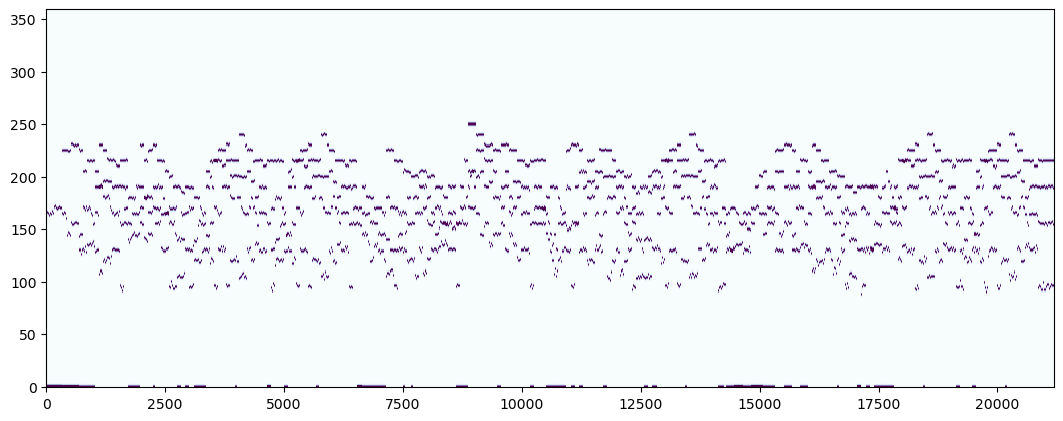

In [45]:
sscs_plot_random('mix')

## 06 - Getting data splits for training

In [49]:
mix, satb = sscs_read_all_voice_splits(sscs_pick_random_song(), SPLIT_SIZE)
print(mix.shape, satb[0].shape, satb[1].shape, satb[2].shape, satb[3].shape)

(18, 360, 128) (18, 360, 128) (18, 360, 128) (18, 360, 128) (18, 360, 128)


In [47]:
'''
voas_cnn = voas_cnn_model()
voas_cnn.compile(optimizer=Adam(learning_rate=5e-3),
                 loss=BinaryCrossentropy(),
                 metrics=[Accuracy()])
'''

'\nvoas_cnn = voas_cnn_model()\nvoas_cnn.compile(optimizer=Adam(learning_rate=5e-3),\n                 loss=BinaryCrossentropy(),\n                 metrics=[Accuracy()])\n'